Цель  - анализ финансовых показателей компаний среди разработчиков информационных технологий. 
- собираем информацию по компаниям с ресурса - https://www.testfirm.ru
- проводим анализ по этой информации

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import re
import time
from google.colab import files # импорт/экспорт файлов
import matplotlib.pyplot as plt


# Создание списка компаний

In [ ]:
url1 = 'https://www.testfirm.ru/' # сайт
url2 = 'https://www.testfirm.ru/rating/63_11_1/' # стр. с рейтингом выручки/ или начало адреса стр. с рейтингом выручки
url3 = 'https://www.testfirm.ru/rating-assets/63_11_1/' # стр. с рейтингом активов
url4 = 'https://www.testfirm.ru/result/' # начало адреса стр с инф. о  компании

## 1 вариант - Сбор информации со списка из первых 50 фирм - с первой страницы фильтра. Минус варианта в том, что в список попадет только 50 компаний. Хотя в рейтинге намного больше фирм. 

In [ ]:
url_list = 'https://www.testfirm.ru/rating' # рейтинг по всем предприятиям 
k_1 = 63   #код деятельности
k_2 = "sverdlovskaya-oblast"  #область
url_list_copm = url_list + '/' + str(k_1) + '/' + k_2 + '/'
text = requests.get(url_list_copm) # 
try:
  text.status_code == 200
  print('Список загружен нормально')
except:
  print('ОШИБКА! Проверяй!')

Список загружен нормально


In [ ]:
# поиск названия компании
text_write = text.text

def find_komp(text_write, N):
    """ф. для поиска ИНН и названия по каждой компании - для формирования url-ссылки на информацию по этой компании
    """
    firma_list = text_write.split('org-link" href="/result/')
    return firma_list[N].split('"')[0]

def find_komp_re(text_write, N):
  """  ф. для поиска ИНН и названия по каждой компании - с помощью регулярных выражений
  """
  pass    

## 2 вариант - Сбор информации со списка из всех фирм фильтра. Попытка собрать данные со всех компаний рейтинга - без ограничений

### - загрузим страницу с рейтингом компаний

In [ ]:
# Рейтинг организаций по выручке - Вид деятельности: 63 "Деятельность в области информационных технологий"
url_list_all = url1 + 'rating/63/' # адрес страницы с рейтингом
text_list_all = requests.get(url_list_all) # 
try:
  text_list_all.status_code == 200
  print('Список загружен нормально')
except:
  print('ОШИБКА! Проверяй!')

Список загружен нормально


### - функции необходимые для кода

In [ ]:
def find_name(url):
    """ ф. находит инфу для url страницы с информацией по компании - состоит из ИНН и названия Компании
    -  inn_firma 
    """
    text = requests.get(url)
    text_find = text.text 
    text_find = text_find.split('class="org-link"')[1].split('result/')[1].split('">')[0]
    return text_find

def find_name_next(url, koef = 1):
    """ ф. находит инфу для url страницы с информацией по следующей компании
    """
    text = requests.get(url)
    text_find = text.text 
    text_find = text_find.split('class="org-link"')[koef].split('result/')[1].split('">')[0]
    return text_find  

In [ ]:
#url_one = 'https://www.testfirm.ru/result/' + name #   https://www.testfirm.ru/result/7708119944_ooo-sibirskaya-internet-kompaniya
def find_info_comp(url_one):
    """ ф.собирает информацию по каждой компании и сохраняет данные в строку
    """
    stroka = [] # собираем информацию сюда
    text_one = requests.get(url_one)
    text_write = text_one.text
    a1 = text_write.split('Организация: ')[1]
    if text_write.split('id="searchText" name="s" value=')[1].split('placeholder')[0]: # название
        stroka.append(text_write.split('id="searchText" name="s" value=')[1].split('placeholder')[0])
    else:
        stroka.append(0)
    stroka.append(a1.split('ИНН: ')[1][:10]) # ИНН
    stroka.append(float(a1.split('<b>')[2].split('<')[0].rstrip())) # активы
    mln = a1.split('Активы на ')[1].split('/b>')[1][:5].rstrip() # млн или тыс
    if mln in 'млн.':
        stroka.append(1)
    elif mln in 'тыс.':
        stroka.append(0.001)
    stroka.append(float(a1.split('Выручка')[1].split('b>')[1].split('<')[0].rstrip())) # выручка
    mln = a1.split('Выручка')[1].split('b>')[2].split('руб')[0].rstrip() # млн ии тыс
    if mln in 'млн.':
        stroka.append(1)
    elif mln in 'тыс.':
        stroka.append(0.001)
    if 'численности ' in text_write:
        stroka.append(int(a1.split('численности ')[1].split('b>')[1].split('<')[0])) # численность человек
    else:
        stroka.append(0) 
    if 'Дополнительные данные ФНС' in text_write:
        stroka.append(float(a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[1].split('<')[0].rstrip())) # доходы 
        stroka.append(float(a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[2].split('<')[0].rstrip())) # расходы
    else:
        stroka.append(0)
        stroka.append(0)
    if "Уплачено налогов" in text_write:
        stroka.append(float(text_write.split("Уплачено налогов")[1].split('b>')[1].split('<')[0].rstrip())) # налоги уплаченные
    else:
        stroka.append(0)
    return stroka

# эта функция - по-быстрее
def find_info_comp_primer(url_one):
    """ ф.собирает информацию по каждой компании и сохраняет данные в строку
    """
    stroka = [] # собираем информацию сюда

    text_one = requests.get(url_one)
    text_write = text_one.text
    a1 = text_write.split('id="searchText" name="s" value=')[1]
    a2 = a1.split(' placeholder')[0] # name
    stroka.append(a2)
#    print(a2)
    a2 = a1.split('ИНН: ')[1].split(' ')[0] # INN
    stroka.append(a2)
#    print(a2)
    if 'Активы на ' in text_write:
        a2 = a1.split('Активы на ')[1].split('<b>')[1].split('</b>') # aktiv
        a2[0] # aktiv
        stroka.append(float(a2[0].replace(' ', '').replace(',','.')))
        mln = a2[1].split(' (')[0] # млн.
        if 'млн.' in mln:
            stroka.append(1)
        elif 'тыс.' in mln:
            stroka.append(0.001)
    else:
        stroka.append(0)
        stroka.append(0)
#    print(a2)
    if 'Выручка за ' in text_write:
        a2 = a1.split('Выручка за ')[1].split('<b>')[1].split(' </b>') # выручка
        stroka.append(float(a2[0].replace(' ', '').replace(',','.')))
        mln = a2[1].split(' (')[0] # млн.
        if 'млн.' in mln:
            stroka.append(1)
        elif 'тыс.' in mln:
            stroka.append(0.001)
    else:
        stroka.append(0)
        stroka.append(0)        
#    print(a2)
    if 'численности ' in text_write:
        stroka.append(int(a1.split('численности ')[1].split('b>')[1].split('<')[0])) # численность человек
    else:
        stroka.append(0) 
#    print(a2)
    if 'Дополнительные данные ФНС' in text_write:
        a2 = a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[1].split('<')[0].rstrip().replace(' ', '')
        stroka.append(float(a2.replace(' ', '').replace(',','.'))) # доходы 
        a2 = a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[2].split('<')[0].rstrip().replace(' ', '')
        stroka.append(float(a2.replace(' ', '').replace(',','.'))) # расходы
    else:
        stroka.append(0)
        stroka.append(0)
#    print(a2)
    if "Уплачено налогов" in text_write:
        stroka.append(float(text_write.split("Уплачено налогов")[1].split('b>')[1].split('<')[0].rstrip().replace(' ', '').replace(',','.'))) # налоги уплаченные
    else:
        stroka.append(0)
#    print(a2) 
    print(stroka)   
    return stroka

# надо бы дописать эту функцию
def find_info_comp_re(List_all_komp, n_comp):
    """ ф.собирает информацию по каждой компании и сохраняет данные в строку с помощью регулярных выражений
    """
    pass

In [ ]:
def info_p(value):
  """ ф. чистит каждое значение - переводит его в int
  """
  pass

### - соберем данные. В этом варианте сбор заканчивается на 553 компании, дальше идет дублирование информации - 2 последних компании начинают дублироваться в списке

In [ ]:
t0 = time.time()
Table_find_values = [] 

name = find_name(url_list_all)      # ф. найдет определитель компании - inn_firma
url_one = url1 + 'result/' + name   # url страницы с информацией о компании
text_one = requests.get(url_one)    # создат объект Response
a = find_info_comp_primer(url_one)             # ф. покажет инф. о компании
#print(a)
Table_find_values.append(a)
inn = name.split('_')[0]            # выделить инн
url_1 = url1 + 'rating/63_11_1/' + inn + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм
print('\t \t 1')

name_next_1 = requests.get(url_1).text.split(name)[1].split('href="/result/')[1].split('">')[0] # найти name следующей компании
inn_next = name_next_1.split('_')[0]
url_next_company = url1 + 'result/' + name_next_1
a = find_info_comp_primer(url_next_company) #  ф. покажет инф. о компании
#print(a)
Table_find_values.append(a)
url_1 = url1 + 'rating/63_11_1/' + inn_next + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм
print('\t \t 2')

for i in range(550):
    name_next_1 = requests.get(url_1).text.split(name_next_1)[1].split('href="/result/')[1].split('">')[0] # найти name следующей компании
    inn_next = name_next_1.split('_')[0]
    url_next_company = url1 + 'result/' + name_next_1
    a = find_info_comp_primer(url_next_company) #  ф. покажет инф. о компании
 #   print(a)
    Table_find_values.append(a)
    url_1 = url1 + 'rating/63_11_1/' + inn_next + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм 
    print('\t \t', i + 3)

### - соберем данные. В этом варианте сбор информации опять заканчивается на 553 компании. А дальше идет дублирование информации с последней компании

In [ ]:
#
t0 = time.time()
Table_find_values = [] 
#
t2 = requests.get(url2).text                 # самая первая стр с рейтингом
#t2 = requests.get('https://www.testfirm.ru/rating/63_11_1/7736536731/').text    # https://www.testfirm.ru/rating/63_11_1/7736536731/
t2 = t2.split('org-link" href="/result/') # инф о самой первой стр с рейтингом
INN_name = t2[1].split('">')[0]                 # INN_name первой компании / t2[1]
INN_name_next_1 = t2[2].split('">')[0] ## INN_name второй компании /  t2[2]
INN_name_next_2 = t2[3].split('">')[0] ## INN_name третьей компании /  t2[2]
Table_find_values.append(find_info_comp_primer(url4 + INN_name))
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_1))
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))
#

for i in range(554):
    INN_next_1 = INN_name_next_1.split('_')[0] # инн следующей следующей компании
    url = url2 + INN_next_1 + '/'
    t2 = requests.get(url).text                 #  стр с рейтингом 
    t3 = t2.split(INN_name_next_1)[1].split('org-link" href="/result/') #стр с рейтингом после компании, разбивка по компаниям
    INN_name_next_1 = t3[1].split('">')[0]
    INN_name_next_2 = t3[2].split('">')[0]
    Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))
#
t1 = time.time() - t0
t1
# возможно ли оптимизировать время, если подправить функцию сбора данных по странице
# остановилось на 7736536731  ГС СЕРВИС   место 554 - потом только дублировалось

### - соберем данные. В этом варианте сбор информации доходит до 2750 компании и обрывается. Буду проверять.

In [ ]:
# попробуем обойти ограничение
t0 = time.time()
Table_find_values = [] 
LIST_komp = []

t2 = requests.get(url2).text                 # самая первая стр с рейтингом
t2 = t2.split('org-link" href="/result/') # инф о самой первой стр с рейтингом
INN_name = t2[1].split('">')[0]                 # INN_name первой компании / t2[1]
INN_name_next_1 = t2[2].split('">')[0] ## INN_name второй компании /  t2[2]
INN_name_next_2 = t2[3].split('">')[0] ## INN_name третьей компании /  t2[2]
#print(1)
Table_find_values.append(find_info_comp_primer(url4 + INN_name))
#print(2)
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_1))
#print(3)
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))

for i in range(4185):
#    print(i + 4)
    INN_name_0 = INN_name_next_2
#    print('INN_name_0 - ', INN_name_0)
    INN_next_0 = INN_name_next_2.split('_')[0] # инн следующей следующей компании
    url = url2 + INN_next_0 + '/' 
#    print('url - ', url)
    t2 = requests.get(url).text                 #  стр с рейтингом 
    t3 = t2.split(INN_name_next_2)[1].split('org-link" href="/result/') #стр с рейтингом после компании, разбивка по компаниям
    INN_name_next_1 = t3[1].split('">')[0]
#    print('INN_name_next_1 - ', INN_name_next_1)
    INN_name_next_2 = t3[2].split('">')[0]
#    print('INN_name_next_2 - ', INN_name_next_2)
    url_next_1 = url4 + INN_name_next_1
#    print('url_next_1 - ', url_next_1)
    url_next_2 = url4 + INN_name_next_2
#    print('url_next_2 - ', url_next_2)
    if INN_name_next_1 not in LIST_komp:           # если нет в списке такого имени, то соберем инфу о компании
        Table_find_values.append(find_info_comp_primer(url_next_1)) 
        LIST_komp.append(INN_name_next_1) # добавим имя в список имен
    else:
        print('все пропало))')
    if INN_name_next_2 not in LIST_komp:           # если нет в списке такого имени, то соберем инфу о компании
        Table_find_values.append(find_info_comp_primer(url_next_2))    
        LIST_komp.append(INN_name_next_2) # добавим имя в список имен
    else:
        print('все пропало))')
      #  else:
      #      print('Все пропало!!!')
    if len(LIST_komp) > 10:
        LIST_komp.pop() # удалить элемент с индексом 0 - пусть в списке останется всего 10 позиций (LIST_komp будет у нас стеком)
    if i % 100 == 0:
        print(i + 4) 
t1 = time.time() - t0
t1


In [ ]:
len(LIST_komp) # 918 
# надо проверить почему длина увеличивается более 10

918

### - посмотрим время затраченное на сбор инфы

In [ ]:
print('время сбора данных для 6500 компаний- \t{} мин.'.format(round( t1 / 60, 2))) # 217.5 мин./ 177.87 мин. после корректировки функции
# 183.09 мин. по 1 варианту
# для 560 комп - 15.62 мин. 1 вариант сбора
# для 550 комп - 	21.33 мин. 2 вариант сбора
# для 2800 - 29,45мин

время сбора данных для 6500 компаний- 	29.45 мин.


In [ ]:
177.87 / 60 # сколько часов для сбора данных для 6500 позиций

2.9645

# Сбор данных по каждой компании - тут только тестирование

In [ ]:
#url2 # 'https://www.testfirm.ru/rating/63_11_1/'

inn = '9721060588'
url_komp = url2 + inn + '/'        # 'https://www.testfirm.ru/rating/63_11_1/' + inn + '/'
t2 = requests.get(url_komp)
t3 = t2.text

mesto = t3.split('success selected')[1].split('pos="')[1].split('"')[0]  # № места
INN = t3.split('success selected')[1].split('pos="')[1].split('"')[2] # INN
INN_name = t3.split('success selected')[1].split('result/')[1].split('">')[0] # INN_name
INN_name_next_1 = t3.split('success selected')[1].split('class="org-link" href="/result/')[2].split('">')[0]
INN_name_next_2 = t3.split('success selected')[1].split('class="org-link" href="/result/')[3].split('">')[0]

print(mesto)
print(INN)
print(INN_name) # проверяемое INN_name
print(INN_name_next_1) # следующее INN_name
print(INN_name_next_2) # следующе следующее INN_name 

stroka = [] # собираем информацию сюда
url_comp_test = 'https://www.testfirm.ru/result/' + INN_name # ссылка на стр. с инф. о компании
find_info_comp_primer(url_comp_test) # ф. об инф. компании 

print('готово')

551
9721060588
9721060588_ooo-platforma-servis
7743808295_ooo-tekhnologii-xxi-vek
7743869121_ooo-it-prof
['"ПЛАТФОРМА СЕРВИС"', '9721060588', 19.1, 1, 62.8, 1, 36, 62.8, 79.8, 9.7]
готово


# Анализ данных. Тут пробую анализ данных собранных по списку компаний

In [ ]:
len(Table_find_values) # 2804

In [ ]:
data = pd.DataFrame(Table_find_values)
data.columns = ['name', 'inn', 'aktiv','e_a' , 'revenue', 'e_v', 'staff', 'income', 'expenses', 'nalog'] 
# name, inn, aktiv/активы, revenue/выручка, персонал/staff,   доходы/income,    расходы/expenses, налоги/tax
data = data[:1843]
data.tail(5)

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
1838,"""Справочные системы""",6501247835,1.39,1.0,8.37,1,1,8.37,7.47,513.0
1839,"""Современные образовательные технологии""",7224035147,16.40,1.0,8.35,1,3,8.35,2.83,423.0
1840,"""УКС""",6670036839,1.34,1.0,8.34,1,6,8.35,8.20,370.0
1841,"""БИГПАУЭР НЬЮС""",7703818321,1.87,1.0,8.34,1,2,8.40,5.59,516.0
1842,"""ТОП СПОТ""",7735574389,16.10,1.0,8.34,1,4,8.36,7.21,817.0


In [ ]:
#загрузить файл на лок.машину
data.to_csv('data_find_values.csv')  # запишем в файл

In [ ]:
# загрузим файл с лок.машины на колаб
uploaded = files.upload()

Saving data_find_values.csv to data_find_values (2).csv


In [ ]:
data = pd.read_csv('data_find_values.csv', index_col= 'Unnamed: 0') # определить загруженный файл в таблицу

In [ ]:
data.head(3)

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
0,"""Сибирская Интернет Компания""",7708119944,47403.0,1.0,52074.0,1,0,0.0,0.0,0.0
1,"""МЭЙЛ РУ""",7743001840,198742.0,1.0,45582.0,1,0,0.0,0.0,0.0
2,"""Центр программ лояльности""",7702770003,8723.0,1.0,32778.0,1,166,33174.0,30617.0,1680.0


In [ ]:
data.e_a.value_counts() # кол-во активов больше и меньше млн. / 
#data.e_v.value_counts() # кол-во активов больше и меньше млн. /   

1.000    1777
0.001      65
0.000       1
Name: e_a, dtype: int64

In [ ]:
data.info() # тип данных в таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843 entries, 0 to 1842
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1843 non-null   object 
 1   inn       1843 non-null   object 
 2   aktiv     1843 non-null   float64
 3   e_a       1843 non-null   float64
 4   revenue   1843 non-null   float64
 5   e_v       1843 non-null   int64  
 6   staff     1843 non-null   int64  
 7   income    1843 non-null   float64
 8   expenses  1843 non-null   float64
 9   nalog     1843 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 144.1+ KB


In [ ]:
data_1 = data.copy() # скопируем файл

In [ ]:
data_1.head(3) # проверим , что скопировалось

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
0,"""Сибирская Интернет Компания""",7708119944,47403.0,1.0,52074.0,1,0,0.0,0.0,0.0
1,"""МЭЙЛ РУ""",7743001840,198742.0,1.0,45582.0,1,0,0.0,0.0,0.0
2,"""Центр программ лояльности""",7702770003,8723.0,1.0,32778.0,1,166,33174.0,30617.0,1680.0


In [ ]:
# заведем новые столбцы
data_1['AKTIV'] = data_1['aktiv'] * data_1['e_a']
data_1['SALE'] = data_1['revenue'] * data_1['e_v']
#data_1.head()
# удалим старые столбцы
data_1 = data_1.drop(['aktiv', 'e_a', 'revenue', 'e_v'], axis= 1)
data_1.head(3)

,name,inn,staff,income,expenses,nalog,AKTIV,SALE
0,"""Сибирская Интернет Компания""",7708119944,0,0.0,0.0,0.0,47403.0,52074.0
1,"""МЭЙЛ РУ""",7743001840,0,0.0,0.0,0.0,198742.0,45582.0
2,"""Центр программ лояльности""",7702770003,166,33174.0,30617.0,1680.0,8723.0,32778.0


In [ ]:
data_1.loc[:,['AKTIV', 'SALE']].describe() # 

,AKTIV,SALE
count,1843.000000,1843.000000
mean,263.094530,208.350011
std,4930.770393,1865.622168
min,0.000000,8.340000
25%,5.270000,15.800000
50%,13.800000,31.800000
75%,39.150000,74.550000
max,198742.000000,52074.000000


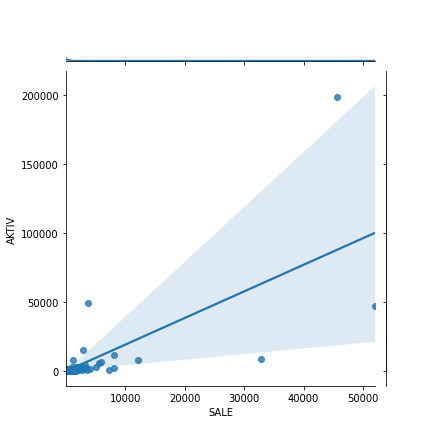

In [ ]:
# совместное распределение по выручке и активам
sns.jointplot(x='SALE', y='AKTIV', data=data_1, kind='reg');

### SALE / рассмотрим выручку компаний

Text(0, 0.5, 'Выручка_компании')

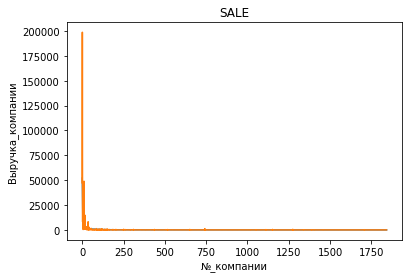

In [ ]:
# распределение выручки компаний
data_1.SALE.plot()
data_1.AKTIV.plot()
plt.title('SALE')

plt.xlabel('№_компании')
plt.ylabel('Выручка_компании')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


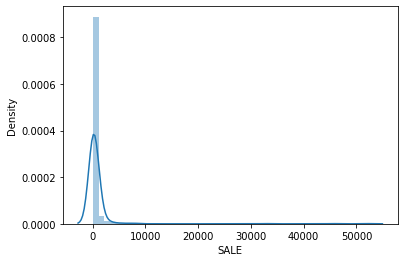

In [ ]:
# гистограмма и график плотности распределения выручки компаний
sns.distplot(data_1['SALE'])

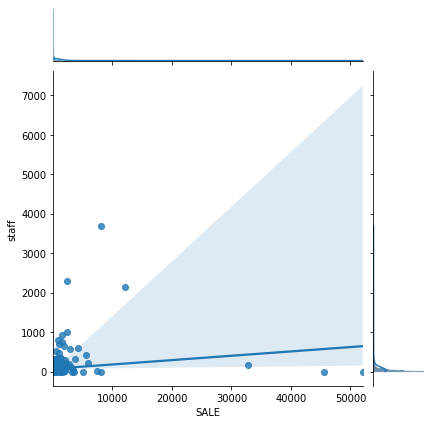

In [ ]:
# совместное распределение по выручке и персоналу
sns.jointplot(x='SALE', y='staff', data=data_1, kind='reg');

### AKTIV / рассмотрим активы компаний 

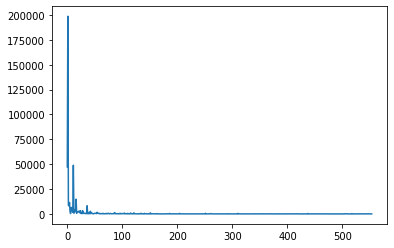

In [ ]:
# график распределения активов компаний
data_1.AKTIV.plot()

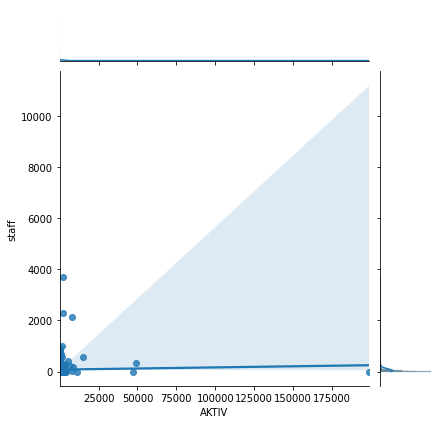

In [ ]:
# совместное распределение по активам и персоналу
sns.jointplot(x='AKTIV', y='staff', data=data_1, kind='reg');

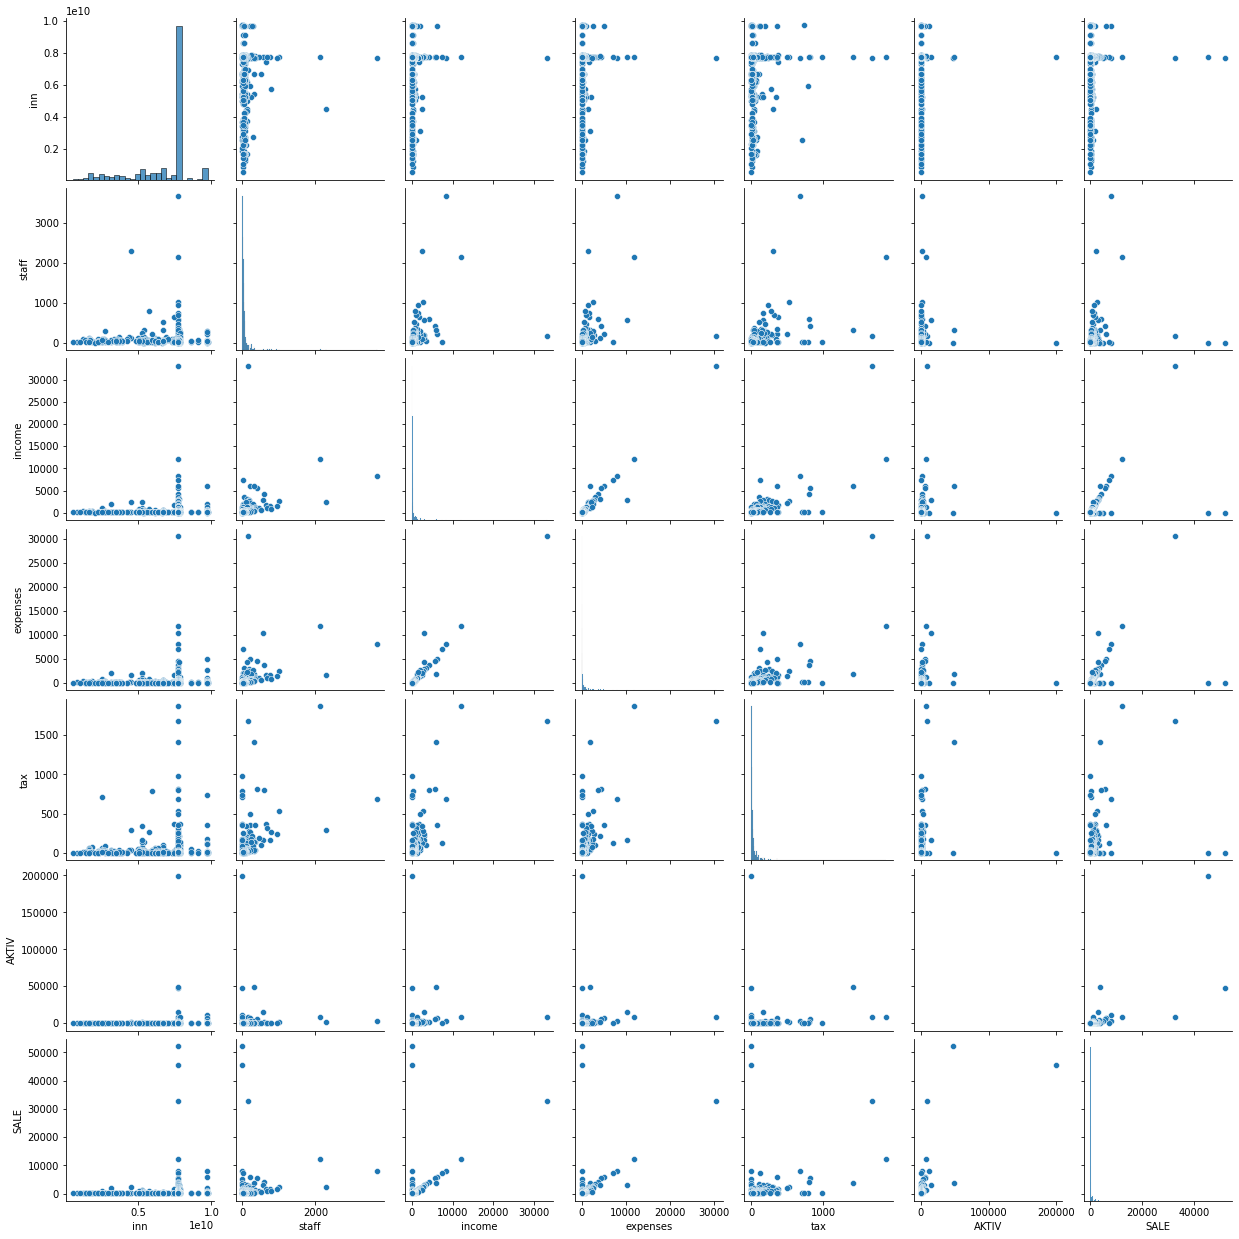

In [ ]:
# отношение между всеми парами переменных
sns.pairplot(data_1)

In [ ]:
# разобьем все компании на группы / до 1млн / от 1млн до 10млн / от 10млн до 100млн / от 100млн до 1000 / больше 1000
def grup(val):
    if x < 1:
        return '<_1'
    elif x >= 1 and x < 99:
        return '1_100'
    elif x > 100 and x < 999:
        return '100_1000'
    elif x >1000 and x < 9999:
        return '1000_10000'
    else:
        return '10000_>'
data_1['groups'] = data_1['VYR'].apply(lambda x: grup(x), axis = 1)
data_1.head(3)

In [ ]:
# анализ продолжится дальше